In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
from matplotlib import dates

In [641]:
# 데이터 추출

In [2]:
df = pd.read_excel("노면결빙_ 제시 데이터.xlsx", sheet_name = "통합", header = 1)

df = df.rename(columns={"대기온도" : "외부 대기온도", "대기온도.1" : "최대 대기온도", "대기온도.2" : "최소 대기온도",
                   "온도" : "이슬점 온도", "온도1" : "노면온도1", "온도2" : "노면온도2", "요약" : "시편상태 요약"})   # 컬럼명을 알기 쉬운 단어들로 정리함
df = df.replace("---", 0).fillna(0) # 공백인 셀 혹은 "---"인 셀들에 대해 모두 0 값으로 정의
df1 = df.copy()

index1 = df1[(df1["날씨"] == 0) & (df1["시편상태 요약"] == 0)].index  # 날씨가 나와있지 않거나 시편상태의 정보가 동시에 나와있지 않은 데이터는 결빙 예측에 포함시키지 않음.
df2 = df1.drop(index1) # 따라서 해당 index를 가진 데이터는 제거

# 1분단위인 시간을 모두 5분단위 시간으로 통일
# 따로 시간의 시와 분에 대한 열을 추가하여 필요한 데이터 행을 가져올 수 있게 만들어줌

df2 = df2.astype({"시간" : "str"})
df2["분"] = [s.split(":")[1] for s in df2["시간"]]
df2["시"] = [s.split(":")[0] for s in df2["시간"]]
df2 = df2.astype({"분" : "int"})
df2 = df2.astype({"시" : "int"})
df3 = df2.loc[df2["분"] % 5 == 0]

df4 = df1.iloc[:df3.index[0]-1,:]
df4 = df4.astype({"시간" : "str"})
df4["분"] = [s.split(":")[1] for s in df4["시간"]]
df4["시"] = [s.split(":")[0] for s in df4["시간"]]
df4 = df4.astype({"분" : "int"})
df4 = df4.astype({"시" : "int"})
df5 = df4.loc[df4["분"] % 5 == 0]
df6 = df5.loc[(df5["분"] == int(df3["분"].values[0])) & (df5["시"] == int(df3["시"].values[0]) - 4)]
df7 = df5.loc[df6.index[-1]:,:]

dat = pd.concat([df7, df3], axis = 0)
fdata = dat.drop(["분","시"], axis = 1)
dat1 = fdata.reset_index(drop=True)

In [3]:
a = list(fdata["노면온도1"].values)
b = np.arange(len(a))
c = []
for i in b:
    if i < 12:
        c.append(0)
    elif i >= 12:
        c.append(a[i] - a[i-12])
df8 = pd.DataFrame(c, columns = ["노면온도 변화량"])
df9 = df8.astype({"노면온도 변화량" : "float"})

fdata1 = pd.concat([dat1, df9], axis = 1)

d = list(fdata["날씨"].values)
e = np.arange(len(d))
f = []
for i in e:
    if i < 36:
        f.append(0)
    elif i >= 36:
        g = []
        for j in np.arange(i-36,i+1):
            g.append(d[j])
        if g.count("비") >= 1:
            f.append(1)
        else:
            f.append(0)
            
df10 = pd.DataFrame(f, columns = ["3시간이내 비 여부"])
fdata2 = pd.concat([fdata1, df10], axis = 1)

In [4]:
# 알고리즘 1번 - 응결

fdata2["algorithm1"] = np.where(fdata2["상대습도"] >= 65,
                                np.where(round(fdata2["노면온도1"],5) <= round(fdata2["이슬점 온도"] + 5,5),
                                         np.where(fdata2["노면온도1"] <= fdata2["외부 대기온도"],
                                                  np.where(fdata2["외부 대기온도"] <= 5,
                                                           np.where(fdata2["노면온도1"] <= 0, "결빙",
                                                                    np.where(fdata2["노면온도1"] <= 1,
                                                                             np.where(fdata2["노면온도 변화량"] <= -1, "결빙","습윤상태"),
                                                                             "습윤상태")),"습윤상태"),"건조상태"),"건조상태"),"건조상태")

In [5]:
# 알고리즘 2번 - 강수
fdata2["algorithm2"] = np.where(fdata2["3시간이내 비 여부"] == 1,
                                np.where(fdata2["외부 대기온도"] <= 0,
                                         np.where(fdata2["노면온도1"] <= 0, "결빙","습윤상태"), "습윤상태"), "건조상태")

In [6]:
# 알고리즘 3번 - 적설
fdata2["algorithm3"] = np.where(fdata2["날씨"] == "눈", "결빙", "없음")

In [7]:
# 알고리즘 4번 - 수막
fdata2["algorithm4"] = np.where(fdata2["수막두께"] > 1,
                                np.where(fdata2["노면온도1"] <= 0, "결빙", "없음"), "없음")

In [8]:
# 알고리즘 6번 - 풍속
fdata2["algorithm6"] =  np.where(fdata2["노면온도1"] <= 0,
                               np.where(round((fdata2["이슬점 온도"] - fdata2["노면온도1"]),5) > 0.5,
                                        np.where(fdata2["풍속"] > float(2), "결빙", "습윤상태"), "건조상태"), "건조상태")

In [9]:
df12 = fdata2[["algorithm1","algorithm2","algorithm3","algorithm4","algorithm6"]]

a1 = list(df12["algorithm1"].values)
a2 = np.arange(len(a1))
a3 = []
for i in a2:
    if i < 48:
        a3.append(0)
    elif i >= 48:
        a4 = []
        for j in np.arange(i-47,i+1):
            a4.append(a1[j])
        if a4.count("결빙") >= 1:
            a3.append(1)
        else:
            a3.append(0)

df_1 = pd.DataFrame(a3, columns = ["1_결빙"])
da_1 = pd.concat([df12, df_1], axis = 1)

In [10]:
b1 = list(df12["algorithm2"].values)
b2 = np.arange(len(b1))
b3 = []
for i in b2:
    if i < 48:
        b3.append(0)
    elif i >= 48:
        b4 = []
        for j in np.arange(i-47,i+1):
            b4.append(b1[j])
        if b4.count("결빙") >= 1:
            b3.append(1)
        else:
            b3.append(0)

df_2 = pd.DataFrame(b3, columns = ["2_결빙"])
da_2 = pd.concat([da_1, df_2], axis = 1)

In [11]:
c1 = list(df12["algorithm3"].values)
c2 = np.arange(len(c1))
c3 = []
for i in c2:
    if i < 48:
        c3.append(0)
    elif i >= 48:
        c4 = []
        for j in np.arange(i-47,i+1):
            c4.append(c1[j])
        if c4.count("결빙") >= 1:
            c3.append(1)
        else:
            c3.append(0)

df_3 = pd.DataFrame(c3, columns = ["3_결빙"])
da_3 = pd.concat([da_2, df_3], axis = 1)

In [12]:
d1 = list(df12["algorithm4"].values)
d2 = np.arange(len(d1))
d3 = []
for i in d2:
    if i < 48:
        d3.append(0)
    elif i >= 48:
        d4 = []
        for j in np.arange(i-47,i+1):
            d4.append(d1[j])
        if d4.count("결빙") >= 1:
            d3.append(1)
        else:
            d3.append(0)

df_4 = pd.DataFrame(d3, columns = ["4_결빙"])
da_4 = pd.concat([da_3, df_4], axis = 1)

In [13]:
e1 = list(df12["algorithm6"].values)
e2 = np.arange(len(e1))
e3 = []
for i in e2:
    if i < 48:
        e3.append(0)
    elif i >= 48:
        e4 = []
        for j in np.arange(i-47,i+1):
            e4.append(d1[j])
        if e4.count("결빙") >= 1:
            e3.append(1)
        else:
            e3.append(0)

df_5 = pd.DataFrame(e3, columns = ["6_결빙"])
da_5 = pd.concat([da_4, df_5], axis = 1)

In [14]:
# 알고리즘 5번 - 결빙상태 지속

min1 = []
for i in[a3,b3,c3,d3,e3]:
    if i.count(1) != 0:
        min1.append(i.index(1))
min1.sort()

q1 = da_5[["1_결빙","2_결빙","3_결빙","4_결빙","6_결빙"]]
q2 = pd.concat([fdata2,q1], axis = 1)
l1 = list(q2["외부 대기온도"])
l2 = list(q2["노면온도1"])

f3 = []
for i in range(len(a3)):
    if i < min1[0]:
        f3.append(0)
    elif i == min1[0]:
        f3.append(1)
    elif i > min1[0]:
        if sum(a3[i-49:i] + b3[i-49:i] + c3[i-49:i] + d3[i-49:i] + e3[i-49:i] + f3[i-49:i]) >= 1:
            if l1[i] <= 0 or l2[i] <= 0:
                f3.append(1)
            else:
                f3.append(0)
        else:
            f3.append(0)
            
g3 = []
for i in range(len(f3)):
    if f3[i] == 0:
        g3.append("없음")
    else:
        g3.append("결빙")

q3 = pd.DataFrame(g3, columns = ["algorithm5"])
da_7 = pd.concat([fdata2,q3], axis = 1)
final_data = da_7.drop(["노면온도 변화량", "3시간이내 비 여부"], axis = 1)

In [15]:
final_data["algorithm"] = np.where(((final_data["algorithm1"] == "결빙") | (final_data["algorithm2"] == "결빙") |
                                    (final_data["algorithm3"] == "결빙") | (final_data["algorithm4"] == "결빙") |
                                    (final_data["algorithm5"] == "결빙") | (final_data["algorithm6"] == "결빙")) == True,
                                   "결빙" ,"비결빙")

index2 = final_data[(final_data["날씨"] == 0) & (final_data["시편상태 요약"] == 0)].index
whiskey_data = final_data.drop(index2).set_index("번호")
whiskey_data["날짜"] = whiskey_data["날짜"].dt.strftime('%Y-%m-%d')

index3 = whiskey_data[whiskey_data["시편상태 요약"] == "확인불가"].index
real_data = whiskey_data.drop(index3)
real_data

,날짜,시간,외부 대기온도,최대 대기온도,최소 대기온도,상대습도,이슬점 온도,풍속,풍향,풍정,...,시편상태,시편상태 요약,날씨,algorithm1,algorithm2,algorithm3,algorithm4,algorithm6,algorithm5,algorithm
번호,,,,,,,,,,,,,,,,,,,,,
1947,2021-01-06,19:40:00,-6.4,-6.4,-6.4,59,-13.1,0.4,ESE,0.03,...,눈,결빙,눈,건조상태,건조상태,결빙,없음,건조상태,결빙,결빙
1952,2021-01-06,19:45:00,-6.6,-6.5,-6.6,69,-11.3,0.4,ENE,0.03,...,눈,결빙,눈,결빙,건조상태,결빙,없음,건조상태,결빙,결빙
1957,2021-01-06,19:50:00,-6.8,-6.7,-6.8,70,-11.3,0.4,NE,0.03,...,눈,결빙,눈,결빙,건조상태,결빙,없음,건조상태,결빙,결빙
1962,2021-01-06,19:55:00,-6.8,-6.8,-6.8,75,-10.5,1.3,ENE,0.08,...,눈,결빙,눈,결빙,건조상태,결빙,없음,건조상태,결빙,결빙
1967,2021-01-06,20:00:00,-6.9,-6.9,-6.9,79,-10.0,0.0,ENE,0.00,...,눈,결빙,눈,결빙,건조상태,결빙,없음,건조상태,결빙,결빙
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43189,2021-03-31,23:35:00,7.3,7.3,7.3,69,2.0,0.0,0,0.00,...,건조,비결빙,0,건조상태,건조상태,없음,없음,건조상태,없음,비결빙
43190,2021-03-31,23:40:00,7.3,7.3,7.2,68,1.8,0.0,0,0.00,...,건조,비결빙,0,건조상태,건조상태,없음,없음,건조상태,없음,비결빙
43191,2021-03-31,23:45:00,7.2,7.2,7.2,73,2.6,0.0,0,0.00,...,건조,비결빙,0,건조상태,건조상태,없음,없음,건조상태,없음,비결빙


In [ ]:
# 엑셀 변환

In [ ]:
# pc_data = real_data[["외부 대기온도","상대습도","이슬점 온도","풍속","노면온도1","수막두께","시편상태 요약","algorithm1","algorithm2","algorithm3","algorithm4","algorithm5","algorithm6","algorithm"]]
# pc_data.to_excel("노면_데이터.xlsx")

In [170]:
# real_data.to_excel("결빙_데이터.xlsx")

In [16]:
# 알고리즘 적중률

real_data["알고리즘 적중률"] = np.where(((real_data["시편상태 요약"] == "결빙") & (real_data["algorithm"] == "결빙")) |
                                 ((real_data["시편상태 요약"] == "비결빙") & (real_data["algorithm"] == "비결빙")), 1, 0)


# 알고리즘 결빙 적중률

frz_data = real_data.loc[real_data["시편상태 요약"] == "결빙",:].copy()
frz_data["알고리즘 결빙 적중률"] = np.where(frz_data["algorithm"] == "결빙", 1, 0)

print("데이터 전처리를 통한 5분단위 데이터의 알고리즘 적중률은 약 {0}% 입니다".format(round(real_data["알고리즘 적중률"].mean(), 3) * 100))
print("데이터 전처리를 통한 5분단위 데이터의 알고리즘 결빙 적중률은 약 {0}% 입니다".format(round(frz_data["알고리즘 결빙 적중률"].mean(), 3) * 100))

데이터 전처리를 통한 5분단위 데이터의 알고리즘 적중률은 약 92.7% 입니다
데이터 전처리를 통한 5분단위 데이터의 알고리즘 결빙 적중률은 약 96.1% 입니다


In [ ]:
# 실제 알고리즘과의 차이 비교

In [23]:
dic = pd.read_excel("결빙분석본.xlsx", sheet_name = "통합", header = 1)

In [24]:
dic = dic.replace("---", 0).fillna(0)
index1 = dic[(dic["날씨"] == 0) & (dic["요약"] == 0)].index  # 날씨가 나와있지 않거나 시편상태의 정보가 동시에 나와있지 않은 데이터는 결빙 예측에 포함시키지 않음.
dic1 = dic.drop(index1) # 따라서 해당 index를 가진 데이터는 제거

In [25]:
dic1 = dic1.astype({"Time" : "str"})
dic1["분"] = [s.split(":")[1] for s in dic1["Time"]]
dic1["시"] = [s.split(":")[0] for s in dic1["Time"]]
dic1 = dic1.astype({"분" : "int"})
dic1 = dic1.astype({"시" : "int"})
dic2 = dic1.loc[dic1["분"] % 5 == 0]

dic3 = dic.iloc[:df3.index[0]-1,:]
dic3 = dic3.astype({"Time" : "str"})
dic3["분"] = [s.split(":")[1] for s in dic3["Time"]]
dic3["시"] = [s.split(":")[0] for s in dic3["Time"]]
dic3 = dic3.astype({"분" : "int"})
dic3 = dic3.astype({"시" : "int"})
dic4 = dic3.loc[dic3["분"] % 5 == 0]
dic5 = dic4.loc[(dic4["분"] == int(dic2["분"].values[0])) & (dic4["시"] == int(dic2["시"].values[0])-1)]
dic6 = dic4.loc[dic5.index[-1]:,:]

f_dat = pd.concat([dic6, dic2], axis = 0)
f_data = f_dat.drop(["분","시"], axis = 1)
f_dat1 = f_data.reset_index(drop=True)

In [26]:
# 5분 단위 데이터에서의 알고리즘 결과 추출

f_dat2 = f_dat1.loc[12:,:]
f_dat3 = f_dat2.set_index("번호")

f_dat4 = f_dat3[['①', '②', '③','④', '⑤', '⑥', '요약.1']]
f_dat4 = f_dat4.loc[23219:,:]
f_dat5 = whiskey_data[["algorithm1","algorithm2","algorithm3","algorithm4","algorithm5","algorithm6","algorithm"]]
f_dat5 = f_dat5.loc[23219:,:]


# 실제 알고리즘 결과와 코드로 구현한 알고리즘 결과 비교


real_list = ['①', '②', '③','④', '⑤', '⑥', '요약.1']
test_list = ["algorithm1","algorithm2","algorithm3","algorithm4","algorithm5","algorithm6","algorithm"]
re_count1 = []
re_count2 = []
re_count3 = []
re_count4 = []
te_count1 = []
te_count2 = []
te_count3 = []
te_count4 = []



for i,j in zip(real_list, test_list):
    real_al = list(f_dat4['{0}'.format(str(i))])
    test_al = list(f_dat5['{0}'.format(str(j))])
    real = []
    test = []

    for i in range(len(real_al)):
        if real_al[i] == "결빙":
            real.append(1)
        elif real_al[i] == "건조":
            real.append(2)
        elif real_al[i] == "습윤":
            real.append(3)
        else:
            real.append(4)
        
    for i in range(len(test_al)):
        if test_al[i] == "결빙":
            test.append(1)
        elif test_al[i] == "건조상태":
            test.append(2)
        elif test_al[i] == "습윤상태":
            test.append(3)
        else:
            test.append(4)
    re_count1.append(real.count(1))
    re_count2.append(real.count(2))
    re_count3.append(real.count(3))
    re_count4.append(real.count(4))
    
    te_count1.append(test.count(1))
    te_count2.append(test.count(2))
    te_count3.append(test.count(3))
    te_count4.append(test.count(4))

re_result = pd.DataFrame((zip(re_count1,re_count2,re_count3,re_count4)), columns = ['결빙', '건조','습윤','없음'])
te_result = pd.DataFrame((zip(te_count1,te_count2,te_count3,te_count4)), columns = ['결빙', '건조','습윤','없음'])

In [27]:
re_result

,결빙,건조,습윤,없음
0,2052,15463,2460,0
1,27,18684,1264,0
2,173,0,0,19802
3,0,0,0,19975
4,4958,0,0,15017
5,5,19552,418,0
6,5033,0,0,14942


In [63]:
te_result

,결빙,건조,습윤,없음
0,2052,15463,2460,0
1,27,18684,1264,0
2,173,0,0,19802
3,0,0,0,19975
4,4958,0,0,15017
5,5,19552,418,0
6,5033,0,0,14942


In [ ]:
# 시각화

In [17]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [18]:
# 특정 날짜별 알고리즘의 영향을 미치는 변수들의 변화지표

In [19]:
def line_graph_of_day(m, d):
    p_data = whiskey_data.copy()
    p_data["날짜와 시간"] = p_data["날짜"] + " " + p_data["시간"]
    p_data["날짜와 시간"] = pd.to_datetime(p_data["날짜와 시간"], format = "%Y-%m-%d %H:%M:%S")
    
    p_ = p_data[(p_data["날짜와 시간"].dt.month == m) & (p_data["날짜와 시간"].dt.day == d)]
    d_ = p_.set_index("날짜와 시간")
    
    plt.figure(figsize = (15,8))
    plt.title("<2021년 {0}월 {1}일 변수간 변화량>".format(str(m),str(d)), size = 20)
    plt.plot(d_["외부 대기온도"], label = "temp")
    plt.plot(d_["상대습도"], label = "hum")
    plt.plot(d_["이슬점 온도"], label = "dew")
    plt.plot(d_["풍속"], label = "wind")
    plt.plot(d_["노면온도1"], label = "soil temp")
    plt.xticks(rotation=45)
    plt.xlim(d_.index.min(),d_.index.max())
    plt.xlabel('시간', labelpad=15, fontdict={'size': 14})
    plt.tick_params(axis='x', direction='in', length=3, pad=6, labelsize=12)
    plt.tick_params(axis='y', direction='inout', length=10, pad=15, labelsize=15, width=2)
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_major_locator(dates.MinuteLocator(interval = 30))

In [20]:
# 특정 날짜별 알고리즘별 결빙여부의 수

In [21]:
def bar_graph_of_day(m, d):
    p_data = whiskey_data.copy()
    p_data["날짜와 시간"] = p_data["날짜"] + " " + p_data["시간"]
    p_data["날짜와 시간"] = pd.to_datetime(p_data["날짜와 시간"], format = "%Y-%m-%d %H:%M:%S")
    
    p_ = p_data[(p_data["날짜와 시간"].dt.month == m) & (p_data["날짜와 시간"].dt.day == d)]
    d_ = p_.set_index("날짜와 시간")


    fig, ax = plt.subplots(2,3, figsize = (10,8))
    plt.suptitle("2021/{0}/{1} 알고리즘 별 결빙분류".format(str(m),str(d)), fontsize = 20)

    for i in np.arange(1,7):
        d_1 = d_["algorithm{0}".format(str(i))].value_counts()
        d_1 = d_1.to_frame(name = "count").reset_index()
        x = list(d_1["index"])
        y = list(d_1["count"])
        z1 = ["결빙","건조상태","습윤상태","없음"]
        z2 = [0,0,0,0]
        if len(x) == 1:
            z2[z1.index(x[0])] = y[0]
        if len(x) == 2:
            z2[z1.index(x[0])] = y[0]
            z2[z1.index(x[1])] = y[1]
        if len(x) == 3:
            z2[z1.index(x[0])] = y[0]
            z2[z1.index(x[1])] = y[1]
            z2[z1.index(x[2])] = y[2]
        if len(x) == 4:
            z2[z1.index(x[0])] = y[0]
            z2[z1.index(x[1])] = y[1]
            z2[z1.index(x[2])] = y[2]
            z2[z1.index(x[3])] = y[3]
        
        if i <= 3:
            ax[0, i-1].bar(z1,z2,color = ["#1f77b4","#ff7f0e","#d62728","#2ca02c"], alpha = 0.9)
            ax[0, i-1].set_ylim(0, max(z2)+20)
            ax[0, i-1].set_title("알고리즘{0}".format(str(i)))

            for j, k in enumerate(x):
                ax[0, i-1].text(k, y[j]+ 0.5, y[j], fontsize = 13, horizontalalignment='center', verticalalignment='bottom')

        else:
            ax[1, i-4].bar(z1,z2,color = ["#1f77b4","#ff7f0e","#d62728","#2ca02c"], alpha = 0.9)
            ax[1, i-4].set_ylim(0, max(z2)+20)
            ax[1, i-4].set_title("알고리즘{0}".format(str(i)))
            
            for j, k in enumerate(x):
                ax[1, i-4].text(k, y[j]+ 0.5, y[j], fontsize = 13, horizontalalignment='center', verticalalignment='bottom')
                
    fig.tight_layout()
    plt.show()

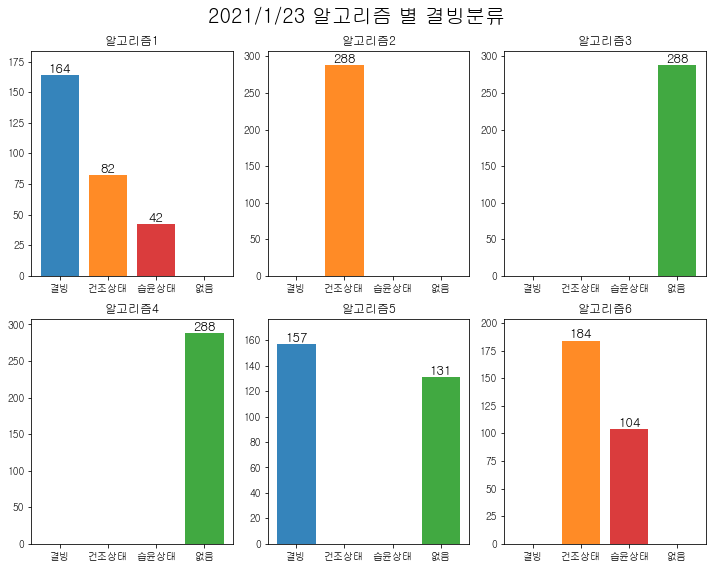

In [22]:
bar_graph_of_day(1,23)

In [23]:
# 월에 따른 일별 결빙과 비결빙일때의 변수 평균 및 구간 변화 그래프

In [24]:
def graph_of_month(x):
    
    p_data = whiskey_data.copy()
    p_data["날짜와 시간"] = p_data["날짜"] + " " + p_data["시간"]
    p_data["날짜와 시간"] = pd.to_datetime(p_data["날짜와 시간"], format = "%Y-%m-%d %H:%M:%S")

    p_ = p_data[(p_data["날짜와 시간"].dt.month == x)]
    a = p_[["날짜와 시간","외부 대기온도","상대습도","이슬점 온도","풍속","노면온도1","날씨","algorithm"]]
    b = pd.DataFrame(a["날짜와 시간"].dt.day).rename(columns = {"날짜와 시간" : "일"})
    c = pd.concat([a,b], axis = 1)


    col_name = c.columns[1:6]
    frz_dat = c.loc[c["algorithm"] == "결빙"]
    nonfrz_dat = c.loc[c["algorithm"] == "비결빙"]

    fig, axes = plt.subplots(5,1)
    for i in range(len(col_name)):
        a = sns.lineplot(x = frz_dat["일"], y = frz_dat["{0}".format(str(col_name[i]))], data = frz_dat, hue = frz_dat["algorithm"], markers = True, palette = 'Paired', ax = axes[i])
        a = sns.lineplot(x = nonfrz_dat["일"], y = nonfrz_dat["{0}".format(str(col_name[i]))], data = nonfrz_dat, hue = nonfrz_dat["algorithm"], markers = True, palette = 'winter', ax = axes[i])
        axes[i].set_title("평균 {0}".format(str(col_name[i])))
    
    plt.suptitle("{0}월 변수별 평균 변화량".format(str(x)), fontsize = 20)
    plt.gcf().set_size_inches(13, 15)
    fig.tight_layout()
    plt.show()

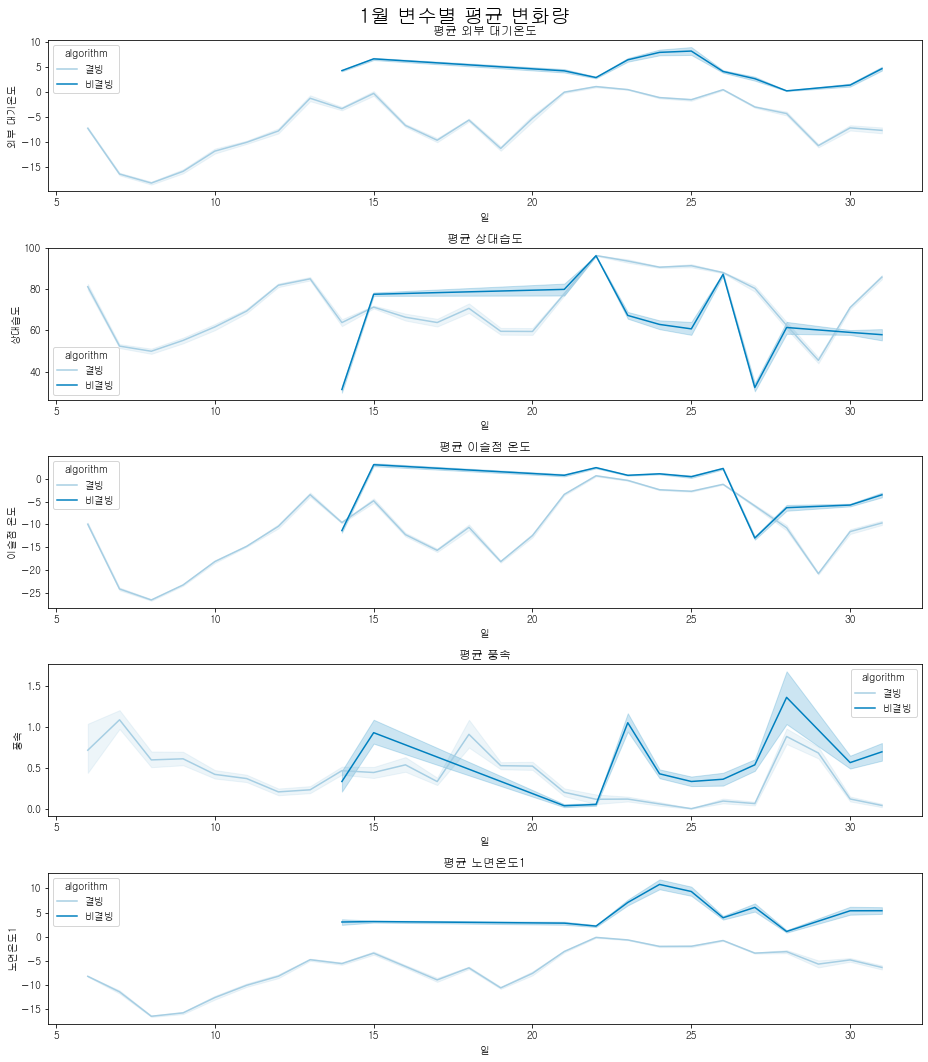

In [25]:
graph_of_month(1)